## Mapping Nutritional Equity: Affordability of a Healthy Diet Around the World

**Harvard University**<br/>
**Fall 2023**<br/>

**Team**:
Aseel Rawashdeh, Mahmoud Elshafeei, Omar Siddiqui, Panthon Imemkamon, and Talha Rehman

<hr style="height:2.4pt">

<a id='contents'></a>

## **Notebook Contents**

- [**Introduction and motivation**](#motivation)
- [**Data Cleaning**](#data_cleaning)
- [**Exploratory Data Analysis**](#eda)
- [**Modeling**](#modeling)
- [**Results**](#results)
- [**Conclusion**](#conclusion)
- [**Future Work**](#future)

In [1]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import geopandas as gpd
from sklearn.linear_model import Lasso

# pandas tricks for better display
pd.options.display.max_columns = 50
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3
import re

import warnings
warnings.filterwarnings("ignore")

<a id='motivation'></a>

## **Introduction and Motivation**
[Return to contents](#contents)

Access to affordable and nutritious food is a fundamental human right, yet a significant proportion of the global population continues to face challenges in affording a healthy diet. The implications of inadequate nutrition are profound, affecting not only individual health but also societal well-being and economic productivity. Recognizing the intricate relationship between agricultural output and food accessibility, our project aims to address this critical issue by leveraging advanced data analytics on a comprehensive dataset sourced from the Food and Agriculture Organization of the United Nations (FAO).

The FAO's extensive database, FAOSTAT, offers a wealth of information on agricultural production, crop yields, and other related factors across more than 245 countries and territories. By focusing on the years spanning from 1961 to the most recent available data, our project spans a considerable timeframe, enabling us to capture long-term trends and variations in food accessibility.

Our primary objective is to develop a predictive model that estimates the  **Percentage of the population unable to afford a healthy diet** based on a variety of predictors derived from FAOSTAT. The key predictors include agricultural output indicators, crop yields of various types, and regional characteristics. This approach allows us to move beyond simple geographical distinctions, acknowledging that regions with similar agricultural yields may share comparable challenges in terms of food accessibility.

The importance of this project lies in its potential to inform targeted interventions and policies aimed at improving food security globally. By identifying the relationships between agricultural indicators and the affordability of healthy diets, we can provide actionable insights for policymakers, governments, and international organizations. Moreover, our findings may contribute to the development of sustainable and resilient agricultural practices that can positively impact food accessibility in the long term.


<a id='data_cleaning'></a>

## **Data Handling & Imputation: FAOSTAT Database**
[Return to contents](#contents)

### Data Transformation
From FAOSTAT, we obtained the following data domains of various countries
- Food Security Indicators
- Cost of a healthy diet
- Land Use
- Food balance

Then we perform the following transformation to merge them into a single dataframe
- Pivot
- Merge on index(Country)

In [2]:
#loading and performing a pivot
df_foodsec = pd.read_csv("food_security_indicators_allcountries.csv")
df_foodsec = df_foodsec.drop(["Domain Code", "Domain", "Area Code (M49)", "Element Code", "Item Code"], axis = 1)
df_foodsec = df_foodsec.pivot(index='Area', columns='Item', values='Value')
df_foodsec.head(2)

Item,Average dietary energy requirement (kcal/cap/day),Average dietary energy supply adequacy (percent) (3-year average),Coefficient of variation of habitual caloric consumption distribution (real number),"Gross domestic product per capita, PPP, (constant 2017 international $)",Incidence of caloric losses at retail distribution level (percent),Minimum dietary energy requirement (kcal/cap/day),Number of children under 5 years affected by wasting (million),Number of children under 5 years of age who are overweight (modeled estimates) (million),Number of children under 5 years of age who are stunted (modeled estimates) (million),Number of moderately or severely food insecure female adults (million) (3-year average),Number of moderately or severely food insecure male adults (million) (3-year average),Number of moderately or severely food insecure people (million) (3-year average),Number of people undernourished (million) (3-year average),Number of severely food insecure female adults (million) (3-year average),Number of severely food insecure male adults (million) (3-year average),Number of severely food insecure people (million) (3-year average),Per capita food supply variability (kcal/cap/day),Percentage of children under 5 years affected by wasting (percent),Percentage of children under 5 years of age who are overweight (modelled estimates) (percent),Percentage of children under 5 years of age who are stunted (modelled estimates) (percent),Political stability and absence of violence/terrorism (index),Prevalence of exclusive breastfeeding among infants 0-5 months of age,Prevalence of moderate or severe food insecurity in the female adult population (percent) (3-year average),Prevalence of moderate or severe food insecurity in the male adult population (percent) (3-year average),Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average),Prevalence of severe food insecurity in the female adult population (percent) (3-year average),Prevalence of severe food insecurity in the male adult population (percent) (3-year average),Prevalence of severe food insecurity in the total population (percent) (3-year average),Prevalence of undernourishment (percent) (3-year average)
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2122,107,0.39,1516.3,3.82,1667,NaN,0.2,2.2,9.7,8.3,31.7,12,3.8,2.7,11.4,31,NaN,3.8,34,-2.53,NaN,85.5,72.9,79.1,33.3,23.5,28.4,30.1
Albania,2487,135,0.29,14516.3,2.64,1909,NaN,<0.1,<0.1,0.4,0.3,0.9,0.1,0.1,<0.1,0.2,13,NaN,13.6,8.8,0.11,NaN,34,26.3,30.2,9.2,5.8,7.5,4.1


In [3]:
df_coahd = pd.read_csv("CoAHD_allcountries.csv")
df_coahd = df_coahd.drop(["Domain Code", "Domain", "Area Code (M49)", "Element Code", "Item Code"], axis = 1)
df_coahd = df_coahd.pivot(index='Area', columns='Item', values='Value')
df_coahd.head(2)

Item,Cost of a healthy diet (PPP dollar per person per day),Number of people unable to afford a healthy diet (million),Percentage of the population unable to afford a healthy diet (percent)
Area,,,
Albania,4.388,0.4,15.9
Algeria,4.043,14.3,32.4


In [4]:
df_landuse = pd.read_csv("land_use_allcountries.csv")
df_landuse = df_landuse.drop(["Domain Code", "Domain", "Area Code (M49)", "Element Code", "Item Code"], axis = 1)
df_landuse = df_landuse.pivot(index='Area', columns=['Item', 'Element'], values='Value')
#combine the indices to the form "first label, second label" to make merging easier
df_landuse.columns = [f"{Item}, {Element}" for Item, Element in df_landuse.columns]
df_landuse.head(2)

,"Country area, Area","Land area, Area","Agriculture, Area","Agricultural land, Area","Cropland, Area","Cropland, Area per capita","Arable land, Area","Temporary crops, Area","Temporary meadows and pastures, Area","Temporary fallow, Area","Permanent crops, Area","Permanent meadows and pastures, Area","Perm. meadows & pastures - Nat. growing, Area","Forest land, Area","Naturally regenerating forest, Area","Planted Forest, Area","Other land, Area","Inland waters, Area","Land area equipped for irrigation, Area","Agriculture area actually irrigated, Area","Agriculture area under organic agric., Area","Agriculture area certified organic, Area","Coastal waters, Area","Land area actually irrigated, Area","Cropland area actually irrigated, Area","Cropland area under organic agric., Area","Cropland area certified organic, Area","Cropland area under protective cover, Area","Perm. meadows & pastures - Cultivated, Area","Farm buildings and Farmyards, Area","Perm. meadows & pastures area actually irrig., Area","Forestry area actually irrigated, Area","Perm. meadows & pastures area under organic agric., Area","Perm. meadows & pastures area certified organic, Area","Inland waters used for aquac. or holding facilities, Area","Inland waters used for capture fisheries, Area","Coastal waters used for aquac. or holding facilities, Area","Coastal waters used for capture fisheries, Area","EEZ used for aquac. or holding facilities, Area","EEZ used for capture fisheries, Area","Exclusive Economic Zone (EEZ), Area","Cropland area under conventional tillage, Area","Cropland area under conservation tillage, Area","Cropland area under zero or no tillage, Area","Land used for aquaculture, Area"
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,65286.0,65223.0,38313.00,38313.00,8051.00,0.201,7829.0,3834.0,0.0,3995.0,222.00,30262.0,30262.0,1208.44,1208.440,0.00,25701.56,63.0,3208.00,2493.0,0.098,0.094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,2875.0,2740.0,1136.33,1136.33,687.53,0.241,599.9,200.9,219.7,179.3,87.63,448.8,NaN,788.90,711.684,70.39,814.77,33.0,361.18,188.0,1.100,0.900,102.0,244.7,188.0,1.1,0.9,1.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_foodbalance = pd.read_csv("food_balances_allcountries.csv")
df_foodbalance = df_foodbalance.drop(["Domain Code", "Domain", "Area Code (M49)", "Element Code", "Item Code (FBS)"], axis = 1)
df_foodbalance = df_foodbalance.pivot(index='Area', columns=['Item', 'Element'], values='Value')
df_foodbalance.columns = [f"{Item}, {Element}" for Item, Element in df_foodbalance.columns]
df_foodbalance.head(2)

,"Population, Domestic supply quantity","Wheat and products, Production","Wheat and products, Domestic supply quantity","Rice and products, Production","Rice and products, Domestic supply quantity","Barley and products, Production","Barley and products, Domestic supply quantity","Maize and products, Production","Maize and products, Domestic supply quantity","Oats, Domestic supply quantity","Millet and products, Production","Millet and products, Domestic supply quantity","Sorghum and products, Domestic supply quantity","Cereals, Other, Domestic supply quantity","Cassava and products, Domestic supply quantity","Potatoes and products, Production","Potatoes and products, Domestic supply quantity","Yams, Domestic supply quantity","Roots, Other, Domestic supply quantity","Sugar cane, Production","Sugar cane, Domestic supply quantity","Sugar beet, Production","Sugar beet, Domestic supply quantity","Sugar (Raw Equivalent), Production","Sugar (Raw Equivalent), Domestic supply quantity",...,"Palm kernels, Domestic supply quantity","Palmkernel Oil, Production","Palm Oil, Production","Ricebran Oil, Domestic supply quantity","Pineapples and products, Production","Coffee and products, Production","Cocoa Beans and products, Production","Beverages, Fermented, Production","Yams, Production","Roots, Other, Production","Maize Germ Oil, Production","Tea (including mate), Production","Alcohol, Non-Food, Production","Cream, Production","Coconuts - Incl Copra, Production","Plantains, Production","Sugar non-centrifugal, Production","Sugar non-centrifugal, Domestic supply quantity","Coconut Oil, Production","Ricebran Oil, Production","Pepper, Production","Meat, Aquatic Mammals, Production","Meat, Aquatic Mammals, Domestic supply quantity","Cloves, Production","Miscellaneous, Production"
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,3900.0,7098.0,459.0,960.0,123.0,133.0,180.0,361.0,-1.0,3.0,4.0,35.0,24.0,0.0,865.0,985.0,-5.0,0.0,38.0,38.0,4.0,4.0,1.0,520.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,0.0,225.0,600.0,0.0,33.0,15.0,22.0,414.0,558.0,35.0,NaN,0.0,0.0,1.0,0.0,259.0,283.0,NaN,0.0,NaN,NaN,24.0,24.0,2.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_predictors = df_coahd.merge(df_landuse, left_index=True, right_index=True, how='outer')
df_predictors = df_predictors.merge(df_foodbalance, left_index=True, right_index=True, how='outer')
df_predictors = df_predictors.dropna(axis=1, how='all')
display(df_predictors.head(2))
df_predictors.to_csv('predictors_merged.csv', index=True)

,Cost of a healthy diet (PPP dollar per person per day),Number of people unable to afford a healthy diet (million),Percentage of the population unable to afford a healthy diet (percent),"Country area, Area","Land area, Area","Agriculture, Area","Agricultural land, Area","Cropland, Area","Cropland, Area per capita","Arable land, Area","Temporary crops, Area","Temporary meadows and pastures, Area","Temporary fallow, Area","Permanent crops, Area","Permanent meadows and pastures, Area","Perm. meadows & pastures - Nat. growing, Area","Forest land, Area","Naturally regenerating forest, Area","Planted Forest, Area","Other land, Area","Inland waters, Area","Land area equipped for irrigation, Area","Agriculture area actually irrigated, Area","Agriculture area under organic agric., Area","Agriculture area certified organic, Area",...,"Palm kernels, Domestic supply quantity","Palmkernel Oil, Production","Palm Oil, Production","Ricebran Oil, Domestic supply quantity","Pineapples and products, Production","Coffee and products, Production","Cocoa Beans and products, Production","Beverages, Fermented, Production","Yams, Production","Roots, Other, Production","Maize Germ Oil, Production","Tea (including mate), Production","Alcohol, Non-Food, Production","Cream, Production","Coconuts - Incl Copra, Production","Plantains, Production","Sugar non-centrifugal, Production","Sugar non-centrifugal, Domestic supply quantity","Coconut Oil, Production","Ricebran Oil, Production","Pepper, Production","Meat, Aquatic Mammals, Production","Meat, Aquatic Mammals, Domestic supply quantity","Cloves, Production","Miscellaneous, Production"
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,65286.0,65223.0,38313.00,38313.00,8051.00,0.201,7829.0,3834.0,0.0,3995.0,222.00,30262.0,30262.0,1208.44,1208.440,0.00,25701.56,63.0,3208.00,2493.0,0.098,0.094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,4.388,0.4,15.9,2875.0,2740.0,1136.33,1136.33,687.53,0.241,599.9,200.9,219.7,179.3,87.63,448.8,NaN,788.90,711.684,70.39,814.77,33.0,361.18,188.0,1.100,0.900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#loading in the data frame and doing some cleaning
rawdf = pd.read_csv('predictors_merged.csv')
rawdf = rawdf.rename({'Area':'Country'}, axis = 1).drop('Number of people unable to afford a healthy diet (million)', axis = 1)
rawdf.head()

,Country,Cost of a healthy diet (PPP dollar per person per day),Percentage of the population unable to afford a healthy diet (percent),"Country area, Area","Land area, Area","Agriculture, Area","Agricultural land, Area","Cropland, Area","Cropland, Area per capita","Arable land, Area","Temporary crops, Area","Temporary meadows and pastures, Area","Temporary fallow, Area","Permanent crops, Area","Permanent meadows and pastures, Area","Perm. meadows & pastures - Nat. growing, Area","Forest land, Area","Naturally regenerating forest, Area","Planted Forest, Area","Other land, Area","Inland waters, Area","Land area equipped for irrigation, Area","Agriculture area actually irrigated, Area","Agriculture area under organic agric., Area","Agriculture area certified organic, Area",...,"Palm kernels, Domestic supply quantity","Palmkernel Oil, Production","Palm Oil, Production","Ricebran Oil, Domestic supply quantity","Pineapples and products, Production","Coffee and products, Production","Cocoa Beans and products, Production","Beverages, Fermented, Production","Yams, Production","Roots, Other, Production","Maize Germ Oil, Production","Tea (including mate), Production","Alcohol, Non-Food, Production","Cream, Production","Coconuts - Incl Copra, Production","Plantains, Production","Sugar non-centrifugal, Production","Sugar non-centrifugal, Domestic supply quantity","Coconut Oil, Production","Ricebran Oil, Production","Pepper, Production","Meat, Aquatic Mammals, Production","Meat, Aquatic Mammals, Domestic supply quantity","Cloves, Production","Miscellaneous, Production"
0,Afghanistan,NaN,NaN,65286.0,65223.0,38313.000,38313.000,8051.000,0.201,7829.000,3834.000,0.000,3995.000,222.000,30262.0,30262.0,1208.440,1208.440,0.000,25701.560,63.0,3208.00,2493.0,0.098,0.094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,4.388,15.9,2875.0,2740.0,1136.330,1136.330,687.530,0.241,599.900,200.900,219.700,179.300,87.630,448.8,NaN,788.900,711.684,70.390,814.770,33.0,361.18,188.0,1.100,0.900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,4.043,32.4,238174.1,238174.1,41316.071,41316.071,8509.571,0.193,7530.600,4682.000,0.000,2848.600,978.971,32806.5,32752.5,1958.333,1396.667,561.667,194899.696,NaN,1382.00,NaN,0.770,0.770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,American Samoa,NaN,NaN,20.0,20.0,2.900,2.900,2.900,0.064,0.970,0.755,0.106,0.108,1.930,0.0,NaN,17.100,17.100,0.000,0.000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,NaN,NaN,47.0,47.0,18.756,18.756,0.756,0.010,0.748,0.207,0.490,0.051,0.009,18.0,NaN,16.000,16.000,0.000,12.244,NaN,0.15,NaN,0.002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Dropping Countries without Healthy Diet Accessibility

While we have 238 countries, a large amount of them (~40%) do not have data on our response variable **Percentage of the population unable to afford a healthy diet**, which is the variable that we are interested in studying. Therefore, we are dropping them from the dataset, leaving 140 countries. It is also important to note that countries that might not report the percentage of population unable to afford a healthy diet may have missing or unreliable data in other domains. And because this is our response variable o which our loss function would be calculated, we decided to not impute the missing columns and drop them instead.

In [8]:
#remving the na observations of the percentage of population unable to afford a healthy diet.
y_col = 'Percentage of the population unable to afford a healthy diet (percent)'
print(rawdf.shape[0])
alldf = rawdf[rawdf[y_col].notna()]
print(alldf.shape[0])
alldf.head()

238
140


,Country,Cost of a healthy diet (PPP dollar per person per day),Percentage of the population unable to afford a healthy diet (percent),"Country area, Area","Land area, Area","Agriculture, Area","Agricultural land, Area","Cropland, Area","Cropland, Area per capita","Arable land, Area","Temporary crops, Area","Temporary meadows and pastures, Area","Temporary fallow, Area","Permanent crops, Area","Permanent meadows and pastures, Area","Perm. meadows & pastures - Nat. growing, Area","Forest land, Area","Naturally regenerating forest, Area","Planted Forest, Area","Other land, Area","Inland waters, Area","Land area equipped for irrigation, Area","Agriculture area actually irrigated, Area","Agriculture area under organic agric., Area","Agriculture area certified organic, Area",...,"Palm kernels, Domestic supply quantity","Palmkernel Oil, Production","Palm Oil, Production","Ricebran Oil, Domestic supply quantity","Pineapples and products, Production","Coffee and products, Production","Cocoa Beans and products, Production","Beverages, Fermented, Production","Yams, Production","Roots, Other, Production","Maize Germ Oil, Production","Tea (including mate), Production","Alcohol, Non-Food, Production","Cream, Production","Coconuts - Incl Copra, Production","Plantains, Production","Sugar non-centrifugal, Production","Sugar non-centrifugal, Domestic supply quantity","Coconut Oil, Production","Ricebran Oil, Production","Pepper, Production","Meat, Aquatic Mammals, Production","Meat, Aquatic Mammals, Domestic supply quantity","Cloves, Production","Miscellaneous, Production"
1,Albania,4.388,15.9,2875.0,2740.0,1136.330,1136.330,687.530,0.241,599.90,200.900,219.70,179.300,87.630,448.8,NaN,788.900,711.684,70.390,814.770,33.0,361.18,188.00,1.100,0.900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,4.043,32.4,238174.1,238174.1,41316.071,41316.071,8509.571,0.193,7530.60,4682.000,0.00,2848.600,978.971,32806.5,32752.50,1958.333,1396.667,561.667,194899.696,NaN,1382.00,NaN,0.770,0.770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Angola,5.031,88.1,124670.0,124670.0,45897.000,45897.000,5690.000,0.165,5373.00,4184.019,587.98,601.002,317.000,40207.0,NaN,66052.313,65251.853,800.473,12720.687,NaN,85.53,NaN,NaN,NaN,...,392.0,10.0,59.0,0.0,663.0,10.0,0.0,794.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Armenia,3.527,41.4,2974.0,2847.0,2042.080,1674.820,503.720,0.180,443.42,227.154,0.00,216.266,60.300,1171.1,1049.87,328.260,310.000,18.260,476.660,127.0,209.43,155.89,0.583,0.297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Australia,2.437,0.7,774122.0,769202.0,387265.000,363519.000,31650.000,1.221,31265.00,25712.322,0.00,5552.678,385.000,331869.0,NaN,134005.100,131614.800,2390.300,247931.900,4920.0,2546.00,1945.00,35687.799,32954.529,...,0.0,NaN,NaN,NaN,74.0,NaN,NaN,9.0,NaN,NaN,1.0,NaN,52.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Null Handling and Imputation
We have 242 potential variables that could have a relationship to the affordability of a healthy diet.

Specifically, the production/supply quantity part is heavily missing. We do not know whether this missing data here means that the country does not produce the item or that there is no available information.

In [9]:
def calculate_null_percentage(df):
    # Calculate the percentage of null values in each column
    null_percentages = (df.isnull().sum() / len(df)) * 100
    # Create a new DataFrame with column names and their respective null percentages
    result_df = pd.DataFrame({
        'Column Names': null_percentages.index,
        'Percent Null': null_percentages.values
    })
    return result_df.sort_values('Percent Null')
sdf = calculate_null_percentage(alldf)
display(sdf.sample(20))

,Column Names,Percent Null
81,"Nuts and products, Production",26.429
130,"Dates, Domestic supply quantity",1.429
108,"Sesameseed Oil, Domestic supply quantity",1.429
47,"Land used for aquaculture, Area",88.571
243,"Miscellaneous, Production",98.571
187,"Soyabean Oil, Production",35.714
226,"Beverages, Fermented, Production",43.571
132,"Grapes and products (excl wine), Domestic supply quantity",0.714
22,"Agriculture area actually irrigated, Area",75.714
239,"Pepper, Production",74.286


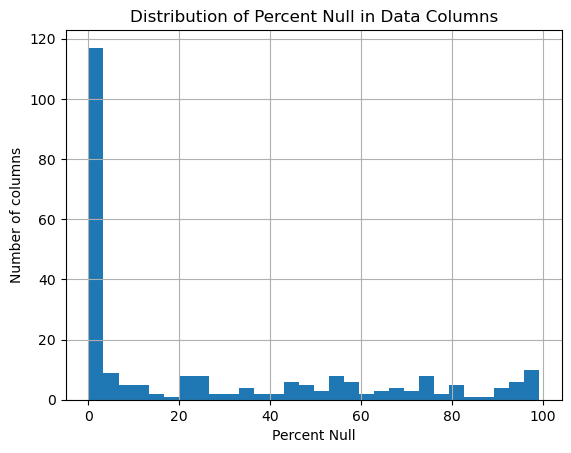

In [10]:
#display the distribution of nulls
sdf['Percent Null'].hist(bins = 30)
plt.title('Distribution of Percent Null in Data Columns')
plt.xlabel('Percent Null')
plt.ylabel('Number of columns')
plt.show()

Unfortunately, the dataset is heavily riddled with missing data. Based on the nature of the dataset it is likely that the missing values come from our pivot transformation -- inferring that the country does not produce that kind of product. Through inspecting the data, we noticed that many of the NA variables may be a result of the country not producing that crop - for example, Russia has NA in the plantains category. Thus, it made the most sense for our group that we impute the missing NAs with zeros, as opposed to the mean or KNN values. We did, however, perform a selection on which columns to impute with zeros, and which to drop altogether. Our thinking is below:

To handle this,

1 - We will drop any column with > 80% missing data. We only have 140 countries in our dataset. If a variable is missing more than that it is unlikely that we will be able to utilize the variable meaningfully. Or, if only a handful of countries have a single feature, the feature coefficient might overfit to a single country and operate more as an indicator of a single/few countries rather than having any predictive power.

2 - If the column has enough data, we will fill missing values with 0 (assume that the country does not produce products of that category) if the data is not available.

In [11]:
#drop empty values
cutoff_keep = 80
fdf = sdf[sdf['Percent Null']<=cutoff_keep]
features = fdf['Column Names'].values

adf = alldf[features].reset_index(drop = True)

all_features = [i for i in adf.columns[1:] if y_col != i]

#fill missing values with 0
for col in adf.columns:
  if(col != y_col):
    adf[col] = adf[col].fillna(0)

#### A Note on Scaling;

Our group considered scaling the variables or perhaps normalizing them to have a mean 0 and a variance 1. We decided against this for a few reasons. Firstly, the magnitude and variance of the variables have important applications for this problem. For example, if a country mainly supports its population off of grains, and produces a little bit of apples too, grain should be weighted more by the model than apples because it represents a large part of the country's agricultural output. By scaling and normalizing, we lose that difference in magnitude, and in a way make all of the features equally important when in reality they are not. Something like soy is much more important for feeding an entire population than blueberries. Additionally, such scaling would assume that the features are distributed roughly normally. This is not an assumption that we felt comfortable with due to our earlier data preprocessing which showed a large number of zeros, suggesting right skewed data.


<a id='eda'></a>

## **Exploratory Data Analysis**
[Return to contents](#contents)

In [12]:
print(f"Number of rows of data: {adf.shape[0]}")
print(f"Number of columns of data: {adf.shape[1]}")
adf.head()

Number of rows of data: 140
Number of columns of data: 218


,Country,"Forest land, Area","Temporary fallow, Area","Temporary meadows and pastures, Area","Temporary crops, Area","Cropland, Area per capita","Cropland, Area","Arable land, Area","Agriculture, Area","Land area, Area","Country area, Area",Percentage of the population unable to afford a healthy diet (percent),Cost of a healthy diet (PPP dollar per person per day),"Agricultural land, Area","Other land, Area","Apples and products, Domestic supply quantity","Vegetables, other, Production","Vegetables, other, Domestic supply quantity","Oranges, Mandarines, Domestic supply quantity","Citrus, Other, Domestic supply quantity","Cocoa Beans and products, Domestic supply quantity","Grapes and products (excl wine), Domestic supply quantity","Fruits, other, Production","Fruits, other, Domestic supply quantity","Coffee and products, Domestic supply quantity",...,"Cropland area certified organic, Area","Sesame seed, Production","Cream, Production","Fish, Liver Oil, Production","Coconuts - Incl Copra, Production","Pimento, Production","Olives (including preserved), Production","Sesameseed Oil, Production","Maize Germ Oil, Production","Coconut Oil, Production","Cocoa Beans and products, Production","Palmkernel Oil, Production","Tea (including mate), Production","Plantains, Production","Yams, Production","Perm. meadows & pastures - Cultivated, Area","Palm kernels, Production","Palm Oil, Production","Perm. meadows & pastures area under organic agric., Area","Perm. meadows & pastures - Nat. growing, Area","Pepper, Production","Agriculture area actually irrigated, Area","Perm. meadows & pastures area certified organic, Area","Sugar non-centrifugal, Domestic supply quantity","Dates, Production"
0,Albania,788.900,179.300,219.70,200.900,0.241,687.530,599.90,1136.330,2740.0,2875.0,15.9,4.388,1136.330,814.770,114.0,906.0,851.0,59.0,1.0,4.0,214.0,162.0,172.0,13.0,...,0.90,0.0,0.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,188.00,0.0,0.0,14.0
1,Algeria,1958.333,2848.600,0.00,4682.000,0.193,8509.571,7530.60,41316.071,238174.1,238174.1,32.4,4.043,41316.071,194899.696,524.0,6379.0,6514.0,1467.0,1.0,43.0,644.0,960.0,994.0,43.0,...,0.77,0.0,0.0,0.0,0.0,15.0,705.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.00,0.0,0.0,0.000,32752.50,0.0,0.00,0.0,0.0,1189.0
2,Angola,66052.313,601.002,587.98,4184.019,0.165,5690.000,5373.00,45897.000,124670.0,124670.0,88.1,5.031,45897.000,12720.687,8.0,745.0,757.0,5.0,446.0,4.0,1.0,99.0,104.0,12.0,...,0.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.00,310.0,59.0,0.000,0.00,0.0,0.00,0.0,0.0,0.0
3,Armenia,328.260,216.266,0.00,227.154,0.180,503.720,443.42,2042.080,2847.0,2974.0,41.4,3.527,1674.820,476.660,101.0,528.0,543.0,32.0,0.0,7.0,235.0,258.0,234.0,23.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.23,0.0,0.0,0.000,1049.87,0.0,155.89,0.0,0.0,0.0
4,Australia,134005.100,5552.678,0.00,25712.322,1.221,31650.000,31265.00,387265.000,769202.0,774122.0,0.7,2.437,363519.000,247931.900,501.0,1541.0,3218.0,381.0,12.0,72.0,1829.0,498.0,720.0,151.0,...,0.00,0.0,7.0,0.0,0.0,0.0,116.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,34617.165,0.00,0.0,1945.00,0.0,0.0,0.0


For many parts of our EDA, we will be performing a visualization of crop yield in different countries. To do so, we will be using the GeoPandas library. If you have not previously done so, you will need to install the geopandas library using the **pip install** command. 
GeoPandas is an open-source Python library that extends the data manipulation and analysis capabilities of the pandas library to support spatial data. It combines the ease of use of pandas with the spatial functionality of other libraries like Shapely and Fiona, making it a powerful tool for working with geospatial data. In our case, we will use it primarily for visualization. Below, we resolve inconsistencies between country names in the FAOSTAT database and in the GeoPandas library. Then, we define two helper functions: one for plotting the globe, and another for plotting specific countries.



In [13]:
#match the names of countries that have different recognized names for geopandas library
mapping_dict = {
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
    'Cabo Verde': 'Cape Verde',
    'Central African Republic': 'Central African Rep.',
    'China, mainland': 'China',
    'Democratic Republic of the Congo': 'Dem. Rep. Congo',
    'Dominican Republic': 'Dominican Rep.',
    'Eswatini': 'eSwatini',
    'Iran (Islamic Republic of)': 'Iran',
    "Lao People's Democratic Republic": 'Laos',
    'Maldives': 'Maldives',
    'Malta': 'Malta',
    'Mauritius': 'Mauritius',
    'Netherlands (Kingdom of the)': 'Netherlands',
    'Republic of Korea': 'South Korea',
    'Republic of Moldova': 'Moldova',
    'Russian Federation': 'Russia',
    'Saint Lucia': 'Saint Lucia',
    'Sao Tome and Principe': 'Sao Tome and Principe',
    'Seychelles': 'Seychelles',
    'Türkiye': 'Turkey',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'United Republic of Tanzania': 'Tanzania',
    'Viet Nam': 'Vietnam'
}


def plot_world(col, df):
    #function to plot world plots using geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    df['Country'] = df['Country'].replace(mapping_dict)

    world2 = world.merge(df[['Country',col]], left_on = 'name', right_on = 'Country', how = 'left')
    worldna = world2[world2[col].isna()]

    # Plot the world map
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    world2.plot(column=col, cmap='plasma', linewidth=0.5, ax=ax, edgecolor='0.8')

    # Plot countries not in your dataset with grey color
    worldna.plot(color='lightgrey', ax=ax)

    # Add color bar
    if(col == 'Percentage of the population unable to afford a healthy diet (percent)'):
        sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=100))
    else:
        sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=world2[col].min(), vmax=world2[col].max()))
    sm._A = []  # Empty array for the data range
    cbar = plt.colorbar(sm, shrink = 0.5)

    # Set plot title
    plt.title('World Map Colored by {}'.format(col))
    plt.axis('off')  # Remove axis

    # Show the plot
    plt.tight_layout()
    plt.show()

#function for plotting specific countries
def plot_countries(df, x_col, y_col='Percentage of the population unable to afford a healthy diet (percent)', country_col='Country', ver_line = 0):
    df = df.dropna(subset=[x_col, y_col])
    #df= df[df[x_col]>0]
    df[x_col] = df[x_col]+1e-3
    ver_line = np.log10(ver_line)

    fig, ax = plt.subplots(figsize=(8, 6))  # Use subplots to get the axes
    df[x_col] = np.log10(df[x_col]).round(2)
    df = df[df[x_col].notna()]
    df[y_col] = df[y_col].round(2)
    ax.scatter(df[x_col], df[y_col])


    l,r = ax.get_xlim()
    if ver_line != 0:
        ax.axvline(x=ver_line, color = 'red')
        mean_left = df[df[x_col]<ver_line][y_col].mean()
        ax.plot([l, ver_line], [mean_left, mean_left], linestyle = '--', color = 'red')
        mean_right = df[df[x_col]>=ver_line][y_col].mean()
        ax.plot([ver_line, r], [mean_right, mean_right], linestyle = '--', color = 'red')

    for i in range(df.shape[0]):
        ax.text(df[x_col].values[i], df[y_col].values[i], df[country_col].values[i], fontsize=8)
    ax.set_xlabel('log '+x_col)
    ax.set_ylabel(y_col)
    ax.set_xlim(l,r)
    ax.set_title(f"Scatter plot between {x_col} and {y_col}")
    ax.grid(False)
    plt.show()

#### World Map

First, let's visualize our response variable -- the percentage of the population unable to afford a healthy diet -- on the world map.

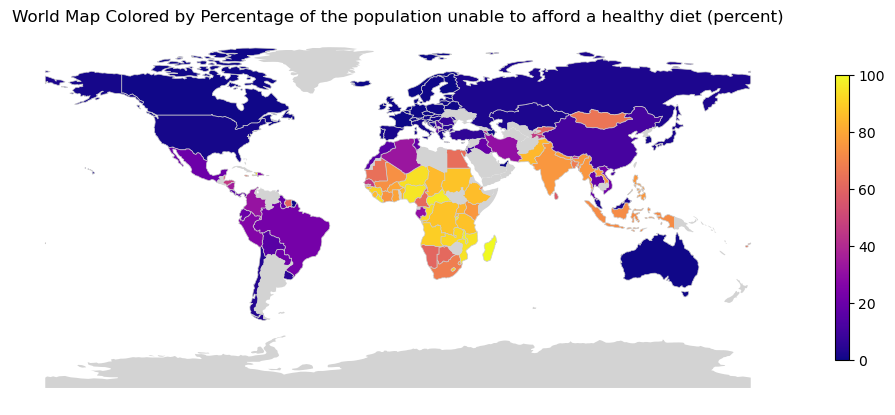

In [14]:
plot_world(y_col, adf)

Notice that countries with high percentages are mostly African/South Asian/Southeast Asian countries. This geographic distribution is important to recapture in a predictive model.

### Top Predictors

Here we will calculate a simple correlation between each feature and our response variable and get a list of potentially strong predictors for our model.

The production of root-based plants appears to be moderately correlated with the inability to afford a healthy diet.

On the other hand, the production of oats, cream, wine, and barley seems to be associated with the affordability of a healthy diet.

In [15]:
ls = []
for feature in all_features:
    ls.append((feature, np.corrcoef(adf[feature], adf[y_col])[0][1].round(2)))
sdf = pd.DataFrame(ls, columns = ['Feature','Correlation with Response Variable']).sort_values('Correlation with Response Variable', ascending = False)
display(sdf.head(10)) #Top positive correlation (associated with inability to afford healthy diet)
display(sdf.tail(10)) #Top negative correlation (associated with less inability to afford a healthy diet)

,Feature,Correlation with Response Variable
192,"Sesame seed, Production",0.29
204,"Plantains, Production",0.28
118,"Plantains, Domestic supply quantity",0.27
180,"Cassava and products, Production",0.27
10,Cost of a healthy diet (PPP dollar per person per day),0.25
78,"Cassava and products, Domestic supply quantity",0.25
84,"Roots, Other, Domestic supply quantity",0.24
177,"Roots, Other, Production",0.24
68,"Beverages, Fermented, Domestic supply quantity",0.20
166,"Beverages, Fermented, Production",0.20


,Feature,Correlation with Response Variable
142,"Sugar beet, Domestic supply quantity",-0.26
188,"Sugar beet, Production",-0.26
77,"Oats, Domestic supply quantity",-0.30
176,"Oats, Production",-0.30
123,"Cream, Domestic supply quantity",-0.31
70,"Wine, Domestic supply quantity",-0.31
193,"Cream, Production",-0.31
159,"Barley and products, Production",-0.32
80,"Barley and products, Domestic supply quantity",-0.34
85,"Population, Domestic supply quantity",NaN


We can visualize some of the top predictors on the map

Plantains seem to be produced in warmer climates like the Philippines and some African countries. These countries also have a higher percentage of the population unable to afford a healthy diet. Plantain production may be a strong geographic indicator for those countries

Similarly, Sugar beet seems to be produced in colder climates, which coincidentally have the USA, Russia, and European countries where most population can afford a healthy diet. This is an important feature for capturing that geography.

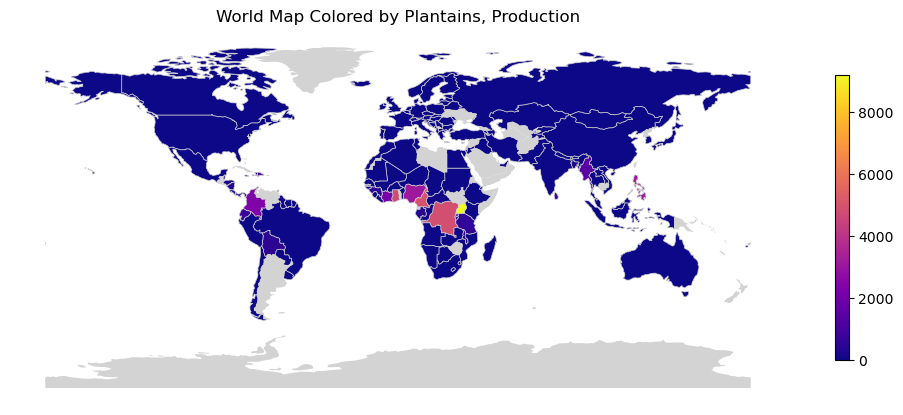

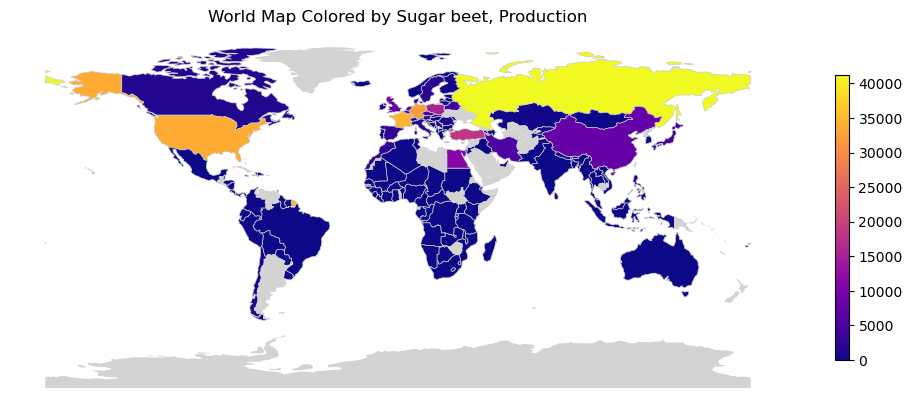

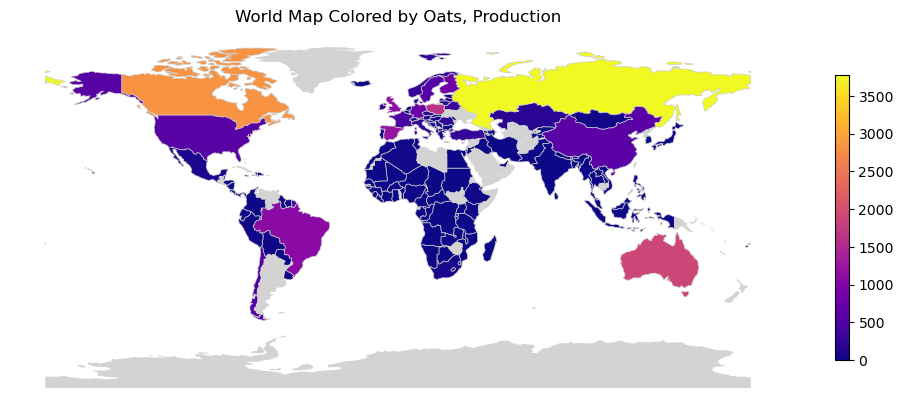

In [16]:
plot_world('Plantains, Production', adf)
plot_world('Sugar beet, Production', adf)
plot_world('Oats, Production', adf)


Plantain is associated with a higher percentage of the population unable to afford a healthy diet. Coincidentally we can see that it is a warm-climate plant and is produced in Central America, Africa, and Southeast Asia. On the other hand, oats are associated with a lower percentage of the population unable to afford a healthy diet. Coincidentally we can see that it is a colder-climate plant and is produced in Europe, North America, and some South American countries.

## High dimensionality of features

The most notable part of our dataset is that we have more features than we have data points. This is an issue in modeling as it theoretically guarantees overfitting. We will demonstrate this in more detail in the **Modeling section**.

### PCA Exploration of dimensionality

We can use PCA to extract the principal components of our dataset.

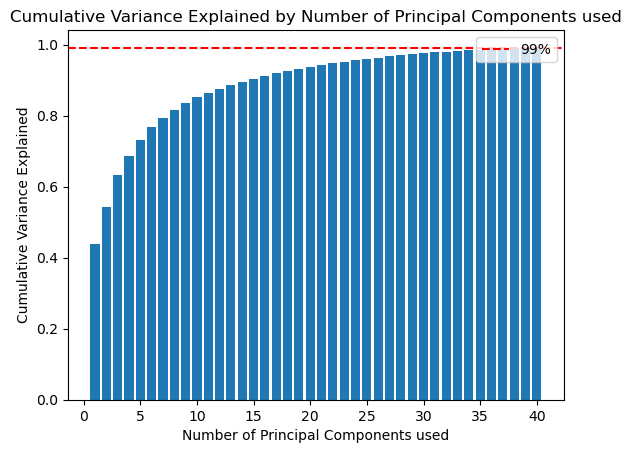

In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(adf[all_features])

pca = PCA().fit(scaled_data)
plt.bar(np.arange(1,41), np.cumsum(pca.explained_variance_ratio_)[:40])
plt.axhline(0.99, color = 'red', label = '99%', linestyle = '--')
plt.title('Cumulative Variance Explained by Number of Principal Components used')
plt.ylabel('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components used')
plt.legend(loc = 'upper right')
plt.show()

Here >99% of the variance can be explained just with 40 components. This suggests that our dataset can be much smaller than the current 216 features.

We will utilize this knowledge about the sub-dimensionality of data in the **modeling section** to show that using PCA regression on the dataset allows us to overfit less with the Linear Regression model.


### PCA Trick for Visualizing Feature Similarity

If we are interested in seeing which feature is similar to which, one way we can do that is via a PCA of the transposed dataset, as explained partially in the advanced section and further reading. This way each feature is a data point and the countries act as features instead. Features that appear close together on the PCA plot are similar.

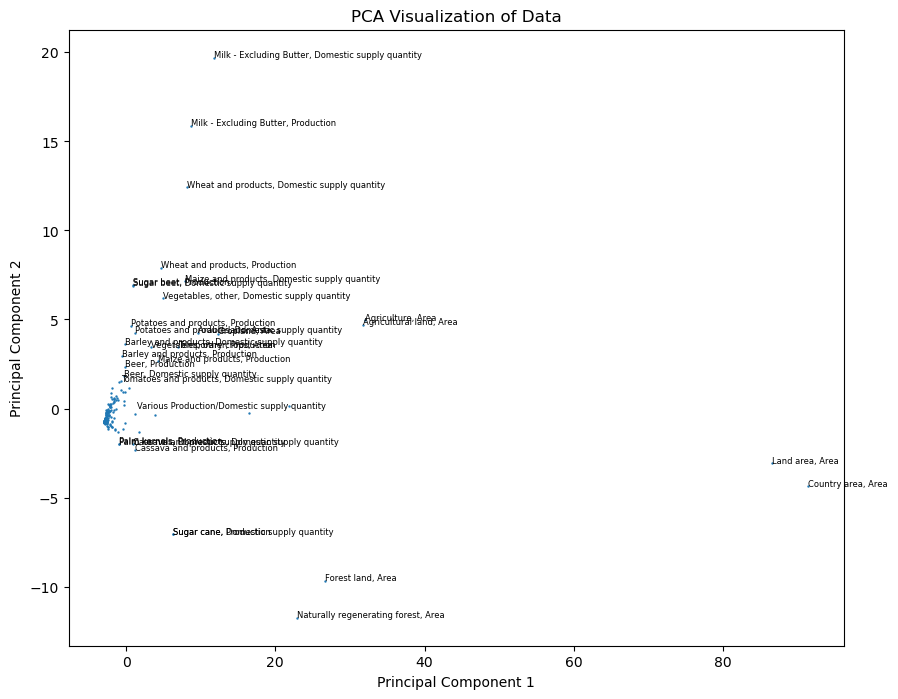

In [18]:
data = adf[all_features].T

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

encoded = PCA(n_components=2).fit_transform(scaled_data)

plt.figure(figsize = (10,8))
for i in range(len(encoded)):
    if(np.abs(encoded[i, 1]-0)> 1.5 or encoded[i, 0]>40):
        plt.text(encoded[i, 0], encoded[i, 1], all_features[i], fontsize = 6)
plt.text(1.5, 0, 'Various Production/Domestic supply quantity', fontsize = 6)

plt.scatter(encoded[:, 0], encoded[:, 1], s = 0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')

plt.show()


The clump in the middle shows that a good amount of features are very similar to each other. This also hints that we might be able to reduce the dimension of this dataset using our understanding of multicollinearity. This can be done through a variety of methods which we will show in the modeling section

Here we would also demonstrate that many pairs of features have very high correlation with one another. We see that many of the features are very highly correlated and there are different classifications for the same type of item. For example, Citrus Other and Citrus are heavily correlated, but may not provide any unique insight that the other cannot. This further shows the importance of feature selection or some sort of nonparametric model to adjust for multicollinearity.

In [19]:
features_corr = adf.iloc[:, 1:].corr()

high_corr = {}

for i in range(features_corr.shape[0]):
    for j in range(i +1, features_corr.shape[1]):
        corr_value = features_corr.iloc[i, j]
        if corr_value > 0.99 or corr_value < -0.99:
            pair = (features_corr.columns[j], features_corr.columns[i])
            high_corr[pair] = corr_value

print("The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:")
display(high_corr)

The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:


{('Naturally regenerating forest, Area',
  'Forest land, Area'): 0.9967475755953926,
 ('Arable land, Area', 'Cropland, Area'): 0.9937655160193237,
 ('Agricultural land, Area', 'Agriculture, Area'): 0.999676775185329,
 ('Vegetables, other, Domestic supply quantity',
  'Vegetables, other, Production'): 0.9993090947981231,
 ('Citrus, Other, Production',
  'Citrus, Other, Domestic supply quantity'): 0.9995739467789487,
 ('Grapes and products (excl wine), Production',
  'Grapes and products (excl wine), Domestic supply quantity'): 0.992522232987809,
 ('Fruits, other, Domestic supply quantity',
  'Fruits, other, Production'): 0.990400144609239,
 ('Tomatoes and products, Production',
  'Tomatoes and products, Domestic supply quantity'): 0.9922168147238148,
 ('Coconuts - Incl Copra, Production',
  'Coconuts - Incl Copra, Domestic supply quantity'): 0.9980869601270415,
 ('Olives (including preserved), Production',
  'Olives (including preserved), Domestic supply quantity'): 0.9956944033814168,


<a id='modeling'></a>

## **Modeling**
[Return to contents](#contents)

![alternative text](./flowchart.png)

In this section, we aim to predict the ercentage of the population unable to afford a healthy diet (percent)' as our variable of interest.

First, we will do a train test split of 80-20.

In [20]:
X = adf.drop(columns=[y_col])
y = adf[y_col]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the name for y_train
y_train = pd.DataFrame({y_col: y_train}).rename(columns={y_col: 'Percentage of the population unable to afford a healthy diet (percent)'})

# Set the name for y_test
y_test = pd.DataFrame({y_col: y_test}).rename(columns={y_col: 'Percentage of the population unable to afford a healthy diet (percent)'})

# Concatenate X_train and y_train
traindf = pd.concat([X_train, y_train], axis=1)

# Concatenate X_test and y_test
testdf = pd.concat([X_test, y_test], axis=1)

print(traindf.shape, testdf.shape)

(112, 218) (28, 218)


For ease of interpretability about how bad our model is we will use **mean absolute error** as the metric as it is straightforward to interpret in this context, because we are predicting a percentage. Additionally, the intention would be to present this to policymakers, so interpretability is especially important in that context, and MAE retains more than MSE.

Also, a point to note is that we are predicting a percentage value. We should clip the model's result to 0 and 100 as that is the possible range of prediction hence the custom MAE scoring function.

In [21]:
def custom_scoring_function(estimator, X, y):
    predictions = estimator.predict(X)
    clipped_predictions = np.clip(predictions, 0, 100)  # Clip predictions between 0 and 100
    mae = np.mean(np.abs(clipped_predictions - y))
    return mae

def clipped_mae(pred, y):
    clipped_predictions = np.clip(pred, 0, 100)  # Clip predictions between 0 and 100
    mae = np.mean(np.abs(clipped_predictions - y)).round(2)
    return mae

#### Baseline Linear Regression with all Features: Guaranteed Overfitting

The most basic model that can be used as a baseline is linear regression. However, due to the nature of **our dataset having very fewer datapoints than the number of columns, it is theoretically guaranteed to overfit severely** (There always exists an n-1 dimension hyperplane that can contain n points in d dimension if n<=d e.g. a plane containing 3 points in 3D, a line between 2 points in 2D).

Here we will show the severe overfitting in our baseline of Linear Regression with all features(~240 features against ~110 data points in the training dataset).


In [22]:
#perform cross-validation for each of our linreg model.
cv = cross_validate(LinearRegression(), traindf[all_features], traindf[y_col], cv=5, scoring = custom_scoring_function,
                               return_train_score = True)

linreg = LinearRegression().fit(traindf[all_features], traindf[y_col])

linreg_train_score = cv['train_score'].mean().round(2)
linreg_val_score = cv['test_score'].mean().round(2)
linreg_test_score = clipped_mae(linreg.predict(testdf[all_features]), testdf[y_col])

print('Linear Regression with all features')
print('Training MAE', linreg_train_score)
print('Validating MAE', linreg_val_score)
print('Test MAE', linreg_test_score)

Linear Regression with all features
Training MAE 0.0
Validating MAE 35.96
Test MAE 54.76


Notice that our training MAE is 0 – or the model overfits perfectly. This is because we have more dimensions than the number of data points.

#### Linear Regression with PCA pre-processing

We have earlier shown in EDA that PCA could retain 99%+ of the variance in the dataset with just the first 40 principal components. Let's check if using PCA to preprocess the dataset allows us to decrease overfitting with the Linear Regression model.

Although we are creating a PCA regression model, we are not using this as a final model by any means. This is due in large part to the loss of interpretability when using PCA, which rather than capturing individual features, captures linear combinations of all the predictors. This model represents how we can improve from the baseline, and allows us to evaluate the other models relative to a model which does not perfectly overfit.

In [23]:
pca = PCA(n_components = 40).fit(traindf[all_features])
cv = cross_validate(LinearRegression(), pca.transform(traindf[all_features]), traindf[y_col], cv=5, scoring = custom_scoring_function,
                               return_train_score = True)

linregpca = LinearRegression().fit(pca.transform(traindf[all_features]), traindf[y_col])

linreg_pca_train_score = cv['train_score'].mean().round(2)
linreg_pca_val_score = cv['test_score'].mean().round(2)
linreg_pca_test_score = clipped_mae(linregpca.predict(pca.transform(testdf[all_features])), testdf[y_col])

print('Linear Regression with all features')
print('Training MAE', linreg_pca_train_score)
print('Validating MAE', linreg_pca_val_score)
print('Test MAE', linreg_pca_test_score)

Linear Regression with all features
Training MAE 14.5
Validating MAE 26.41
Test MAE 31.2


We can see that while our model is still overfitting, we get a lot better result by using PCA to reduce the dimensions.

#### Lowering the dimension with Lasso

To handle the issue of dimensionality mentioned above, as well as the highly correlated features, we can use Lasso Regression to help the model utilize fewer variables as the L1 norm will flatten some predictor values to zero, performing feature selection on the data set for us. We also use k-fold cross-validation to find the best value for alpha. Here, we decided to use 5 folds rather than 10 folds due to the size of our dataset being smaller. If we were to use ten folds, the validation set would be very small, and that could end up not really indicating the best model, as a single abnormal observation in the validation set could have a large effect on model performance if the validation set is small. Thus, we decided to use 5 folds.

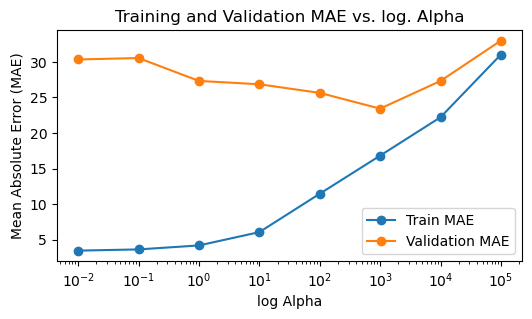

Lasso with best alpha =  1000
Estimated number of non-zero coefficients the Lasso model is using: 34
Training MAE 16.81
Validating MAE 23.42
Test MAE 30.72


In [24]:
#tuning a LASSO model, and saving the best hyperparameters and the MAE scores
np.random.seed(42)
min_train = 101
min_val = 101
train_mae_ls = []
val_mae_ls = []
for alpha in [0.01,0.1,1,10,100,1000, 10000, 100000]:
    cv = cross_validate(Lasso(alpha = alpha), traindf[all_features], traindf[y_col], cv=5, scoring = custom_scoring_function,
                                    return_train_score = True)
    if(cv['test_score'].mean().round(2)<min_val):
        min_train = cv['train_score'].mean().round(2)
        min_val =  cv['test_score'].mean().round(2)
        best_alpha = alpha
    train_mae_ls.append(cv['train_score'].mean().round(2))
    val_mae_ls.append(cv['test_score'].mean().round(2))

plt.figure(figsize = (6,3))
plt.plot([0.01,0.1,1,10,100,1000, 10000, 100000], train_mae_ls, label='Train MAE', marker = 'o')
plt.plot([0.01,0.1,1,10,100,1000, 10000, 100000], val_mae_ls, label='Validation MAE', marker = 'o')
plt.xlabel('log Alpha')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE vs. log. Alpha')
plt.xscale('log')
plt.legend()
plt.show()

lassoreg = Lasso(alpha = best_alpha).fit(traindf[all_features], traindf[y_col])

lasso_train_score = min_train
lasso_val_score = min_val
lasso_test_score = clipped_mae(lassoreg.predict(testdf[all_features]), testdf[y_col])

print('Lasso with best alpha = ', best_alpha)
print('Estimated number of non-zero coefficients the Lasso model is using:', len([i for i in lassoreg.coef_ if np.abs(i)>1e-5]))
print('Training MAE', lasso_train_score)
print('Validating MAE', lasso_val_score)
print('Test MAE', lasso_test_score)

Our best lasso model utilizes just 34 features out of 216. So we see that using fewer variables does help prevent the model from overfitting. It also performs better than the linear regression baseline and PCA baseline.

Next, we will explore solutions that use feature selection instead.

Here we will use only features that strongly correlate with the response variable, either positively or negatively. This type of analysis is known as correlation analysis, and though not explicitly covered in class, is another method that has been used in literature. This model will select which features to use based on the magnitude of their correlation coefficient. The magnitude of the correlation, or **abs_corr** is a hyperparameter that we use cross-validation to tune.

In [25]:
cdf = adf.iloc[:, 1:].corr()[y_col].reset_index().sort_values(y_col)[:-2]
cdf['abs_corr'] = np.abs(cdf[y_col])
cdf = cdf.sort_values('abs_corr', ascending = False).rename({'index':'Features'}, axis = 1)
display(cdf[:20])

,Features,Percentage of the population unable to afford a healthy diet (percent),abs_corr
81,"Barley and products, Domestic supply quantity",-0.345,0.345
160,"Barley and products, Production",-0.316,0.316
194,"Cream, Production",-0.314,0.314
124,"Cream, Domestic supply quantity",-0.314,0.314
71,"Wine, Domestic supply quantity",-0.309,0.309
78,"Oats, Domestic supply quantity",-0.303,0.303
177,"Oats, Production",-0.303,0.303
193,"Sesame seed, Production",0.291,0.291
205,"Plantains, Production",0.276,0.276
181,"Cassava and products, Production",0.270,0.270


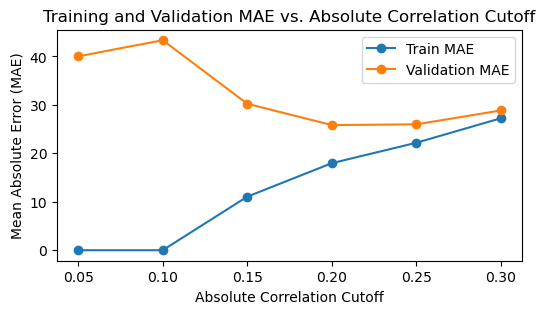

Training MAE 17.97
Validating MAE 25.84
Test MAE 33.62


In [26]:
#Tune cutoff for absolute correlation value
np.random.seed(42)
min_train = 101
min_val = 101
train_mae_ls = []
#performing cross validatin
val_mae_ls = []
for cutoff in [0.05,0.1,0.15,0.2,0.25,0.3]:
    selected_features = cdf[cdf['abs_corr']>cutoff]['Features']
    cv = cross_validate(LinearRegression(), traindf[selected_features], traindf[y_col], cv=5, scoring = custom_scoring_function,
                                    return_train_score = True)
    if(cv['test_score'].mean().round(2)<min_val):
        min_train = cv['train_score'].mean().round(2)
        min_val =  cv['test_score'].mean().round(2)
        best_cutoff = cutoff
    train_mae_ls.append(cv['train_score'].mean().round(2))
    val_mae_ls.append(cv['test_score'].mean().round(2))

#plotting the figute
plt.figure(figsize = (6,3))
plt.plot([0.05,0.1,0.15,0.2,0.25,0.3], train_mae_ls, label='Train MAE', marker = 'o')
plt.plot([0.05,0.1,0.15,0.2,0.25,0.3], val_mae_ls, label='Validation MAE', marker = 'o')
plt.xlabel('Absolute Correlation Cutoff')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE vs. Absolute Correlation Cutoff')
plt.legend()
plt.show()


selected_features = cdf[cdf['abs_corr']>best_cutoff]['Features']
correlation = LinearRegression().fit(traindf[selected_features], traindf[y_col])


correlation_train_score = min_train
correlation_val_score = min_val
correlation_test_score = clipped_mae(correlation.predict(testdf[selected_features]), testdf[y_col])

print('Training MAE', correlation_train_score)
print('Validating MAE', correlation_val_score)
print('Test MAE', correlation_test_score)

Here we see that feature selection also helps with preventing overfitting, performing better than the linear regression baseline and about as well as the PCA regression baseline, but worse than the Lasso model.

With such few data points, our main concern is overfitting. It is unlikely that higher dimension techniques like polynomial regression will help our prediction rather than exacerbate the overfitting problem. This is why we decided against using those methods.

With Linear Regression and Lasso Regression representing the parametric family of models, we will next try KNN Regression and Decision Tree regressor as techniques representing the non-parametric family of models.

### Decision Tree

We first test a decision tree model, tuning the depth hyperparameter over a possible depth of 1, 2, 3, 4, 5, or 6 using cross-validation with 5 folds. This decision tree is not using bagging or boosting, but serves as a nice baseline for a more advanced nonparametric model we will train shortly.

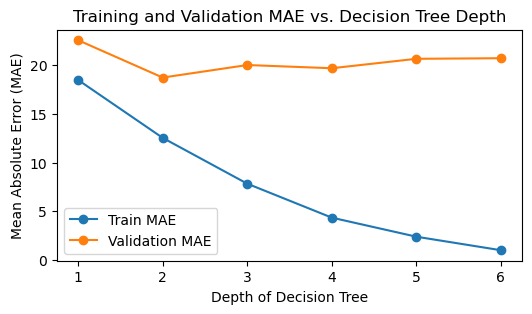

Decision Tree with Depth 2
Training MAE 12.54
Validating MAE 18.74
Test MAE 17.19


In [27]:
np.random.seed(42)
min_train = 101
min_val = 101
train_mae_ls = []
val_mae_ls = []
for d in [1,2,3,4,5,6]:
    cv = cross_validate(DecisionTreeRegressor(max_depth = d), traindf[all_features], traindf[y_col], cv=5, scoring = custom_scoring_function,
                                    return_train_score = True)
    if(cv['test_score'].mean().round(2)<min_val):
        min_train = cv['train_score'].mean().round(2)
        min_val =  cv['test_score'].mean().round(2)
        best_depth = d
    train_mae_ls.append(cv['train_score'].mean().round(2))
    val_mae_ls.append(cv['test_score'].mean().round(2))

plt.figure(figsize = (6,3))
plt.plot(np.arange(1,7), train_mae_ls, label='Train MAE', marker = 'o')
plt.plot(np.arange(1,7), val_mae_ls, label='Validation MAE', marker = 'o')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE vs. Decision Tree Depth')
plt.legend()
plt.show()

dlf = DecisionTreeRegressor(max_depth = best_depth).fit(traindf[all_features], traindf[y_col])

dt_train_score = min_train
dt_val_score = min_val
dt_test_score = clipped_mae(dlf.predict(testdf[all_features]), testdf[y_col])

print('Decision Tree with Depth 2')
print('Training MAE', dt_train_score)
print('Validating MAE', dt_val_score)
print('Test MAE', dt_test_score)

We see that the Decision Tree has better performance than all the parametric models including the baseline. The ideal depth for the decision tree is two, which suggests, which suggests that using some sort of variance reduction method, like bagging, will allow us to increase tree depth without overfitting. Still, non-parametric models seem to be a strong choice over parametric models.

### KNeighborsRegressor

Next, we use KNN regression as another non-parametric model. We have seen in the past psets that KNN regression can be robust to multicollinearity, as PCA did not increase its performance. Thus, we hope it can perform well on our model as well. It also has a nice interpretable meaning in this context, that countries with similar agricultural output likely have a similar amount of people unable to afford a healthy diet. We tune the neighbors hyperparameter using cross-validation with 5 folds.

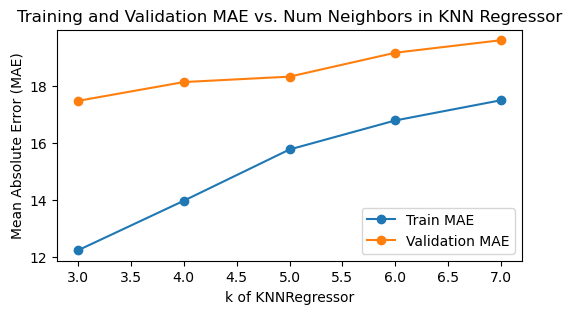

KNN Regressor with 3 Neighbors
Training MAE 12.24
Validating MAE 17.49
Test MAE 35.53


In [28]:
np.random.seed(42)
min_train = 101
min_val = 101
train_mae_ls = []
val_mae_ls = []

scaler = StandardScaler().fit(traindf[all_features])
for k in [3,4,5,6,7]:
    cv = cross_validate(KNeighborsRegressor(n_neighbors = k), scaler.transform(traindf[all_features]), traindf[y_col], cv=5, scoring = custom_scoring_function,
                                    return_train_score = True)
    if(cv['test_score'].mean().round(2)<min_val):
        min_train = cv['train_score'].mean().round(2)
        min_val =  cv['test_score'].mean().round(2)
        best_k = k
    train_mae_ls.append(cv['train_score'].mean().round(2))
    val_mae_ls.append(cv['test_score'].mean().round(2))

plt.figure(figsize = (6,3))
plt.plot(np.arange(3,8), train_mae_ls, label='Train MAE', marker = 'o')
plt.plot(np.arange(3,8), val_mae_ls, label='Validation MAE', marker = 'o')
plt.xlabel('k of KNNRegressor')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE vs. Num Neighbors in KNN Regressor')
plt.legend()
plt.show()

knn = KNeighborsRegressor(n_neighbors = best_k).fit(scaler.transform(traindf[all_features]), traindf[y_col])

knn_train_score = min_train
knn_val_score = min_val
knn_test_score = clipped_mae(knn.predict(testdf[all_features]), testdf[y_col])

print('KNN Regressor with {} Neighbors'.format(best_k))
print('Training MAE', knn_train_score)
print('Validating MAE', knn_val_score)
print('Test MAE', knn_test_score)


As we can see, the best KNN model was the one with three neighbors. Though the validation MSE is better than many of the other models, we see that it performs on par with the parametric models on the test, albeit still a major improvement over the linear regression baseline.

### Random Forest Model

Random Forest, with its usage of bagging, is usually a model that performs very well in situations with severe overfitting (such as our case) because of bagging and the random feature selection. Because our decision tree performed so well, we think Random Forests will also be very strong.

Normally random forest performs poorly in high dimension data because some estimators might not get powerful predictors in the subsampled features they see. We can fix this parameter to make the model see most features at the cost of a smaller difference between base estimators.

We train to find the best hyperparameter of depth for the tree and test for 1, 2, 3, 4, 5,6,7, or 8 using 5-fold cross validation.

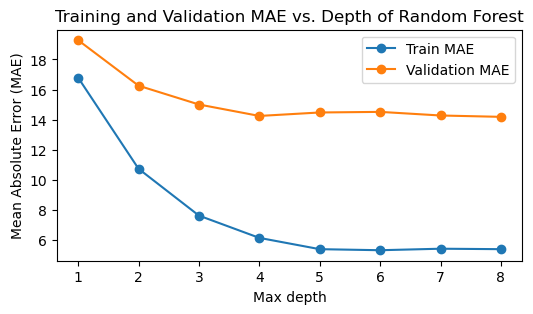

RandomForestRegressor with depth 8
Training MAE 5.4
Validating MAE 14.19
Test MAE 13.91


In [29]:
np.random.seed(42)
min_train = 101
min_val = 101
train_mae_ls = []
val_mae_ls = []

#train hyperparameters
for d in [1,2,3,4,5,6,7,8]:
    cv = cross_validate(RandomForestRegressor(max_depth = d, max_features = 0.9), traindf[all_features], traindf[y_col], cv=5, scoring = custom_scoring_function,
                                    return_train_score = True)
    if(cv['test_score'].mean().round(2)<min_val):
        min_train = cv['train_score'].mean().round(2)
        min_val =  cv['test_score'].mean().round(2)
        best_d = d
    train_mae_ls.append(cv['train_score'].mean().round(2))
    val_mae_ls.append(cv['test_score'].mean().round(2))

#plotting
plt.figure(figsize = (6,3))
plt.plot(np.arange(1,9), train_mae_ls, label='Train MAE', marker = 'o')
plt.plot(np.arange(1,9), val_mae_ls, label='Validation MAE', marker = 'o')
plt.xlabel('Max depth')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE vs. Depth of Random Forest')
plt.legend()
plt.show()

rf = RandomForestRegressor(max_depth = best_d, max_features = 0.9).fit(traindf[all_features], traindf[y_col])

rf_train_score = min_train
rf_val_score = min_val
rf_test_score = clipped_mae(rf.predict(testdf[all_features]), testdf[y_col])

print('RandomForestRegressor with depth {}'.format(best_d))
print('Training MAE', rf_train_score)
print('Validating MAE', rf_val_score)
print('Test MAE', rf_test_score)

Wow! The Random Forest Model performs much better than the baseline and even has stronger performance than the decision tree. Overall, the model has the strongest performance out of any of the candidate models thus far. Cross-validation shows the best depth is 8. It is important to note that with such a deep forest, some of the nice interpretability is lost, which is something that ideally we would like to have conserved. But the interpretability tradeoff is worth it to us in this case, as model performance is much improved.

### Ensemble methods: Blending (209a Component)

After trying both parametric and non-parametric families of models, we will now blend all our models and train a meta-model to output a prediction. Blending involves independent, parallel, heterogeneous learners, and will also satisfy our project's AC209a requirement.

We are combining the linear regression, lasso regression, decision tree, RF, and KNN model into a blended model, using a linear regression meta model.

![alternative text](./blend.png)

In [30]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model_ls = [
    LinearRegression(),
    Lasso(alpha = 1000),
    DecisionTreeRegressor(max_depth = best_depth),
    KNeighborsRegressor(n_neighbors = best_k),
    RandomForestRegressor(max_depth = best_d, max_features = 0.9),
]

model_names = [
    'Linear Regression',
    'Lasso Regression',
    f'Decision Tree (Depth {best_depth})',
    f'KNN Regressor (k = {best_k})',
    f'Random Forest Regressor (d = {best_d})',
]

train_ls = []
val_ls = []
test_ls = []
scaler = StandardScaler()
scaler.fit(X_train_train[all_features])
#fitting all the models to create the updated train set
for model in model_ls:
    model.fit(scaler.transform(X_train_train[all_features]), y_train_train)
    train_ls.append(model.predict(scaler.transform(X_train_train[all_features])).reshape(-1))
    val_ls.append(model.predict(scaler.transform(X_val[all_features])).reshape(-1))
    test_ls.append(model.predict(scaler.transform(X_test[all_features])).reshape(-1))

train_pred = np.array(train_ls).T
val_pred = np.array(val_ls).T
test_pred = np.array(test_ls).T

#creating the meta model
blend_model = LinearRegression()
blend_model.fit(val_pred, y_val)

#predictions for the meta model
pred = blend_model.predict(train_pred)
blend_train_score = clipped_mae(pred, y_train_train).round(2)

pred = blend_model.predict(val_pred)
blend_val_score = clipped_mae(pred, y_val).round(2)

pred = blend_model.predict(test_pred)
blend_test_score = clipped_mae(pred, y_test).round(2)

print('Blended Model')
print('Training MAE', blend_train_score)
#We did fit the blending validation set, does not make sense to report validation score for Blended model
#print('Validating MAE', blend_val_score)
blend_val_score = None
print('Test MAE', blend_test_score)


Blended Model
Training MAE 5.33
Test MAE 16.61


While it might look like our Blended model is doing well, it is still losing to our Random Forest Regressor. The blending technique might need more data for better tuning of the meta model. We do not expect Blending to improve performance as the performance bottleneck is currently from overfitting rather than a lack of model fitting power.

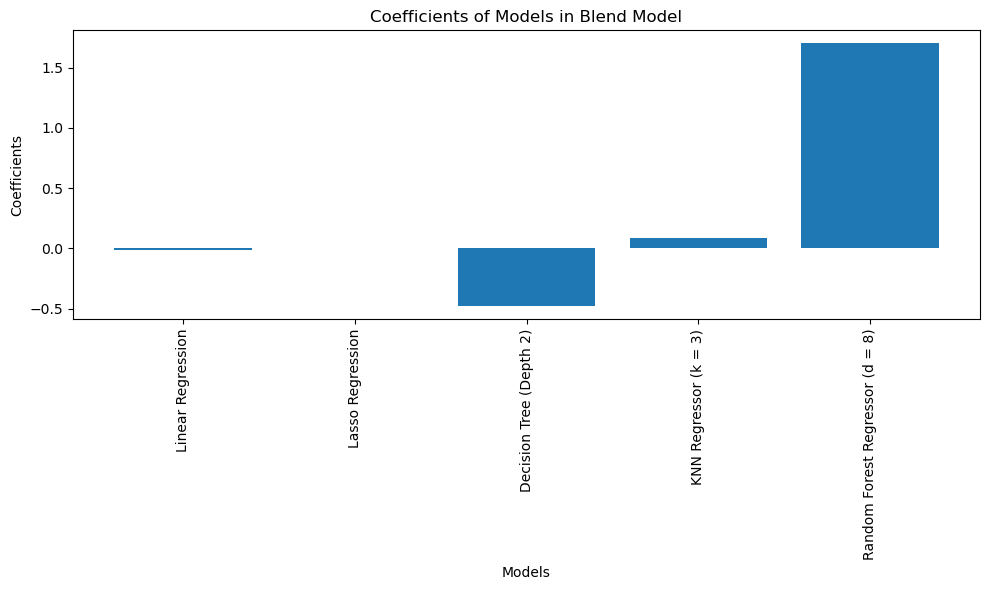

In [31]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(np.arange(len(model_ls)), blend_model.coef_[0])
plt.xticks(np.arange(len(model_ls)), model_names, rotation=90)
plt.xlabel('Models')
plt.ylabel('Coefficients')
plt.title('Coefficients of Models in Blend Model')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Blended model is putting heavy weight on our best model Random Forest Regressor and adjusts it by a bit using the prediction from Decision Tree. This makes sense, as our random forest and decision tree were the two strongest models.

## Summary of Model Performance

In [32]:
#print a df with the performance of our different models
pd.DataFrame([
    {'model': 'Basic Linear Regression',
     'Train MAE': linreg_train_score,
     'Val MAE': linreg_val_score,
    },
    {'model': 'Linear Regression with PCA',
     'Train MAE': linreg_pca_train_score,
     'Val MAE': linreg_pca_val_score,
    },
    {'model': 'LASSO Regression (Baseline Model)',
     'Train MAE': lasso_train_score,
     'Val MAE': lasso_val_score},
    {'model': 'Linear Regression with Manual Feature Selection (Correlation Analysis)',
     'Train MAE': correlation_train_score,
     'Val MAE': correlation_val_score},
    {'model': 'Decision Tree (Depth 2)',
     'Train MAE': dt_train_score,
     'Val MAE': dt_val_score},
    {'model': 'KNN Regressor (k = 5)',
     'Train MAE': knn_train_score,
     'Val MAE': knn_val_score},
    {'model': 'Random Forest Regressor (d = 8)',
     'Train MAE': rf_train_score,
     'Val MAE': rf_val_score},
    {'model': 'Blended Model',
     'Train MAE': blend_train_score,
     'Val MAE': blend_val_score},

]).set_index('model')

,Train MAE,Val MAE
model,,
Basic Linear Regression,0.00,35.96
Linear Regression with PCA,14.50,26.41
LASSO Regression (Baseline Model),16.81,23.42
Linear Regression with Manual Feature Selection (Correlation Analysis),17.97,25.84
Decision Tree (Depth 2),12.54,18.74
KNN Regressor (k = 5),12.24,17.49
Random Forest Regressor (d = 8),5.40,14.19
Blended Model,5.33,NaN


Let's check our result on the test set

In [33]:
data = [
    {'model': 'Basic Linear Regression',
     'Train MAE': linreg_train_score,
     'Val MAE': linreg_val_score,
     'Test MAE': linreg_test_score,
    },
    {'model': 'Linear Regression with PCA',
     'Train MAE': linreg_pca_train_score,
     'Val MAE': linreg_pca_val_score,
     'Test MAE': linreg_pca_test_score,
    },
    {'model': 'LASSO Regression (Baseline Model)',
     'Train MAE': lasso_train_score,
     'Val MAE': lasso_val_score,
     'Test MAE': lasso_test_score,
    },
    {'model': 'Linear Regression with Manual Feature Selection (Correlation Analysis)',
     'Train MAE': correlation_train_score,
     'Val MAE': correlation_val_score,
     'Test MAE': correlation_test_score,
    },
    {'model': 'Decision Tree (Depth 2)',
     'Train MAE': dt_train_score,
     'Val MAE': dt_val_score,
     'Test MAE': dt_test_score,
    },
    {'model': 'KNN Regressor (k = 5)',
     'Train MAE': knn_train_score,
     'Val MAE': knn_val_score,
     'Test MAE': knn_test_score,
    },
    {'model': 'Random Forest Regressor (d = 8)',
     'Train MAE': rf_train_score,
     'Val MAE': rf_val_score,
     'Test MAE': rf_test_score,
    },
    {'model': 'Blended Model',
     'Train MAE': blend_train_score,
     'Val MAE': blend_val_score,
    'Test MAE':blend_test_score,
    },
]
df = pd.DataFrame(data).set_index('model')
df


,Train MAE,Val MAE,Test MAE
model,,,
Basic Linear Regression,0.00,35.96,54.76
Linear Regression with PCA,14.50,26.41,31.20
LASSO Regression (Baseline Model),16.81,23.42,30.72
Linear Regression with Manual Feature Selection (Correlation Analysis),17.97,25.84,33.62
Decision Tree (Depth 2),12.54,18.74,17.19
KNN Regressor (k = 5),12.24,17.49,35.53
Random Forest Regressor (d = 8),5.40,14.19,13.91
Blended Model,5.33,NaN,16.61


And bingo! Our model's performance still hold even on unseen test set! Based on this, we summarize that our RandomForestModel with depth = 8 is the best based on the MAE metric

<a id='results'></a>

## **Discussion of Results**
[Return to contents](#contents)

Our best-performing model is RandomForestRegressor, with the MAE on the test set of 13.91

Here is a visualization of countries in our test set vs its prediction.

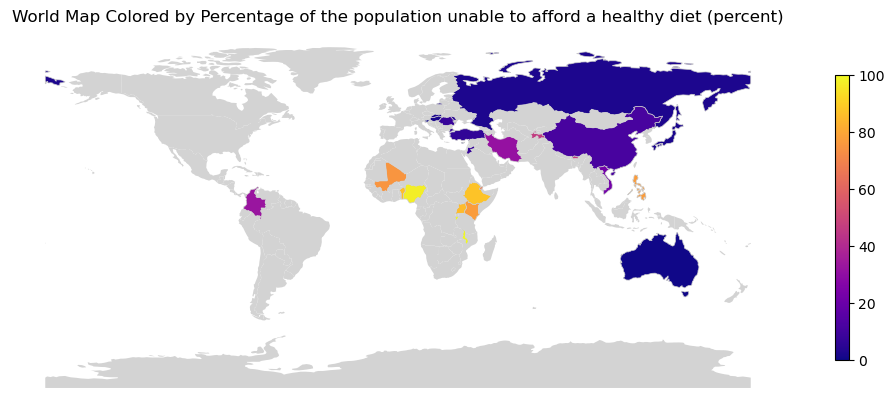

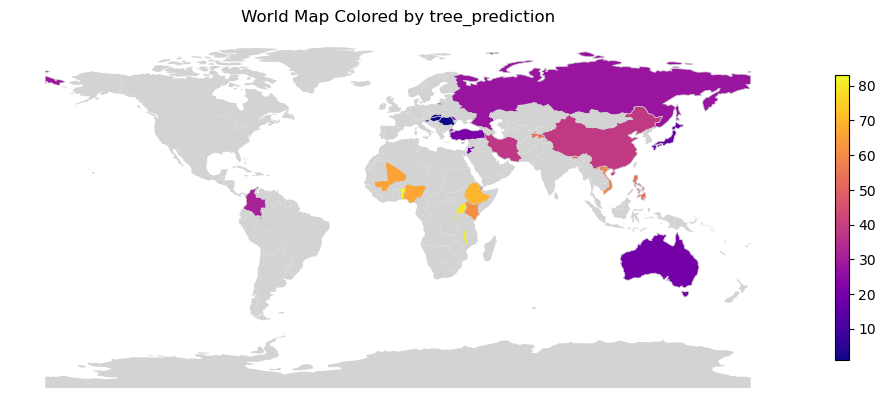

In [34]:
testdf['tree_prediction'] = rf.predict(testdf[all_features])
plot_world(y_col, testdf)
plot_world('tree_prediction', testdf)

**We can see that the model overpredicts the percentage of the population unable to afford a healthy diet in Asian countries, but is decently accurate in Africa/America.**

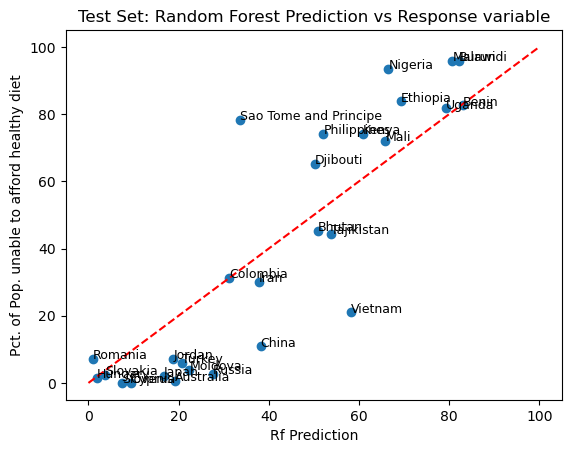

In [35]:
plt.scatter(testdf['tree_prediction'], testdf[y_col])
plt.plot([0,100], [0,100], color = 'red', linestyle = '--')
plt.title('Test Set: Random Forest Prediction vs Response variable')
plt.xlabel('Rf Prediction')
plt.ylabel('Pct. of Pop. unable to afford healthy diet')
for i in range(testdf.shape[0]):
    plt.text(testdf['tree_prediction'].values[i], testdf[y_col].values[i], testdf['Country'].values[i], fontsize = 9)
plt.show()

**Our model generally makes more conservative predictions than the observed data, over-predicting for wealthy countries with less developed neighbors.** For example, We see that it overpredicts for a country like China, whose neighbors in Southeast Asia have a high percentage of people unable to afford a healthy diet.

### Understanding how our model makes prediction

The best-performing model is RandomForest

First, let's look at its feature importance. We can see that the model relies very heavily on the top three predictors vs the rest.

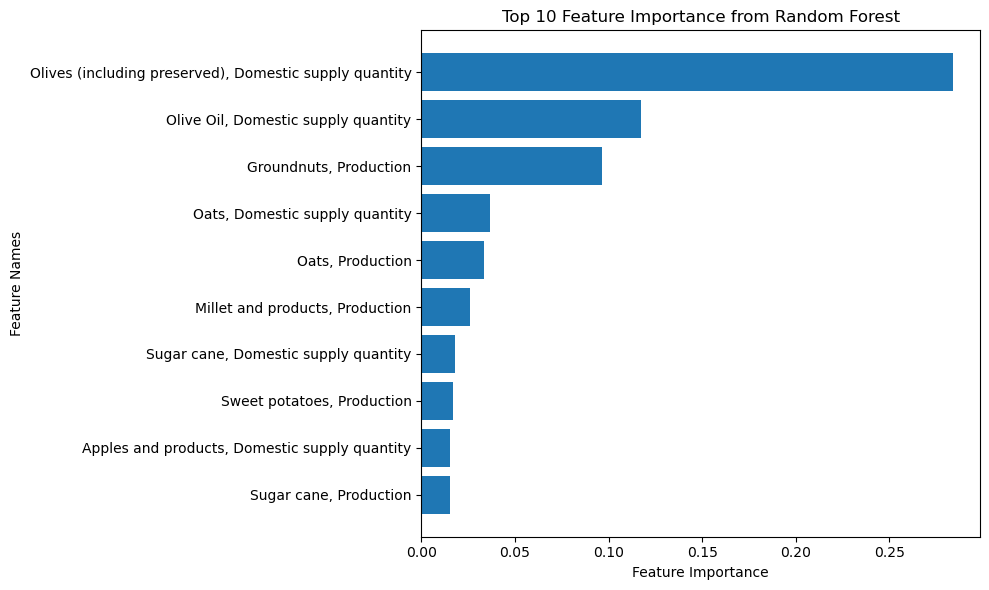

In [36]:
# Get feature importances from the trained model
feature_importance = rf.feature_importances_
feature_names = all_features

top_10_indices = feature_importance.argsort()[-10:][::-1]
top_10_importances = feature_importance[top_10_indices]
top_10_names = [feature_names[i] for i in top_10_indices]

# Plotting top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_names, top_10_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top 10 Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features on top
plt.tight_layout()
plt.show()

If we look at our depth 2 decision tree, we will notice that it uses the same predictor as well.

Visualizing the decision tree


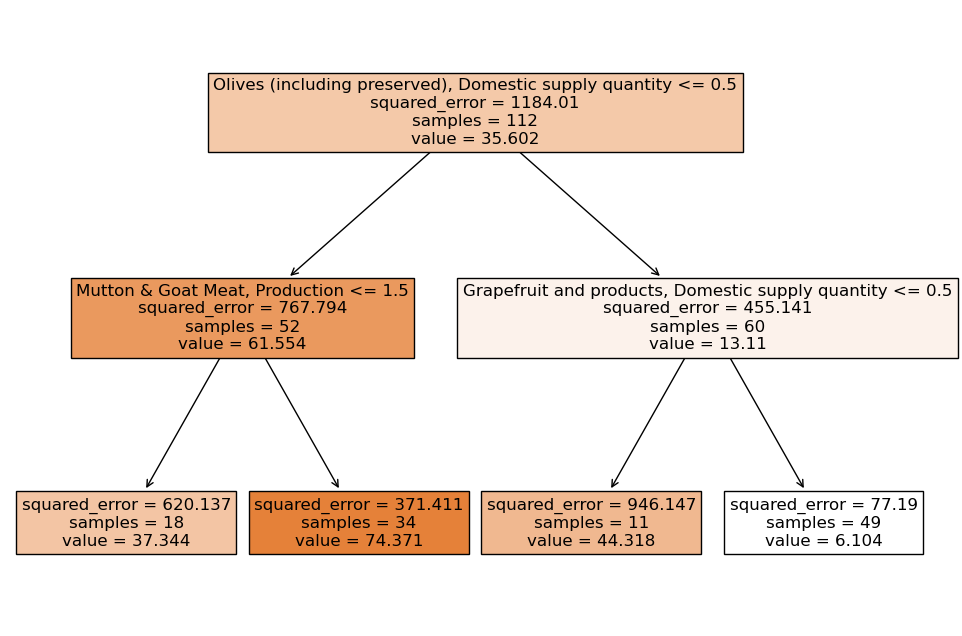

In [37]:
print('Visualizing the decision tree')
plt.figure(figsize = (12,8))
plot_tree(dlf, filled=True, feature_names=all_features, fontsize = 12)
plt.show()

What's so special about Olives' domestic supply?

To understand this, let's look at the world map of the percentage unable to afford a healthy diet vs countries that produces fewer olives than 0.5 unit



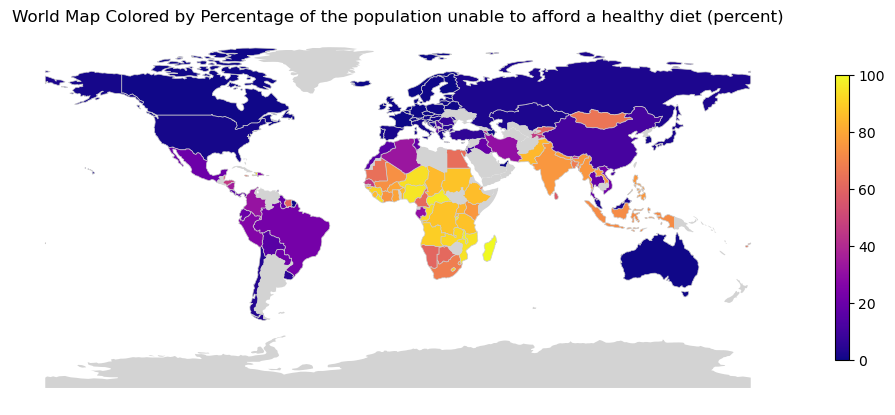

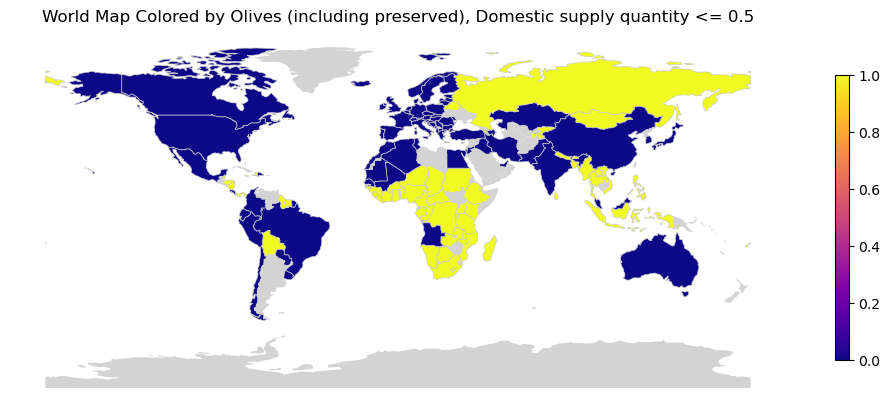

In [38]:
plot_world(y_col, adf)
adf['Olives (including preserved), Domestic supply quantity <= 0.5'] = (1*adf['Olives (including preserved), Domestic supply quantity']<0.5)
plot_world('Olives (including preserved), Domestic supply quantity <= 0.5', adf)

We can see that essentially, Olives production < 0.5 is a proxy for geographical location in Africa/Southeast Asia, in which the model will predict a higher chance of inability to afford a healthy diet

This is confirmed should we look at the scatter plot and the decision boundary, and the average response variable at each side of the decision boundary

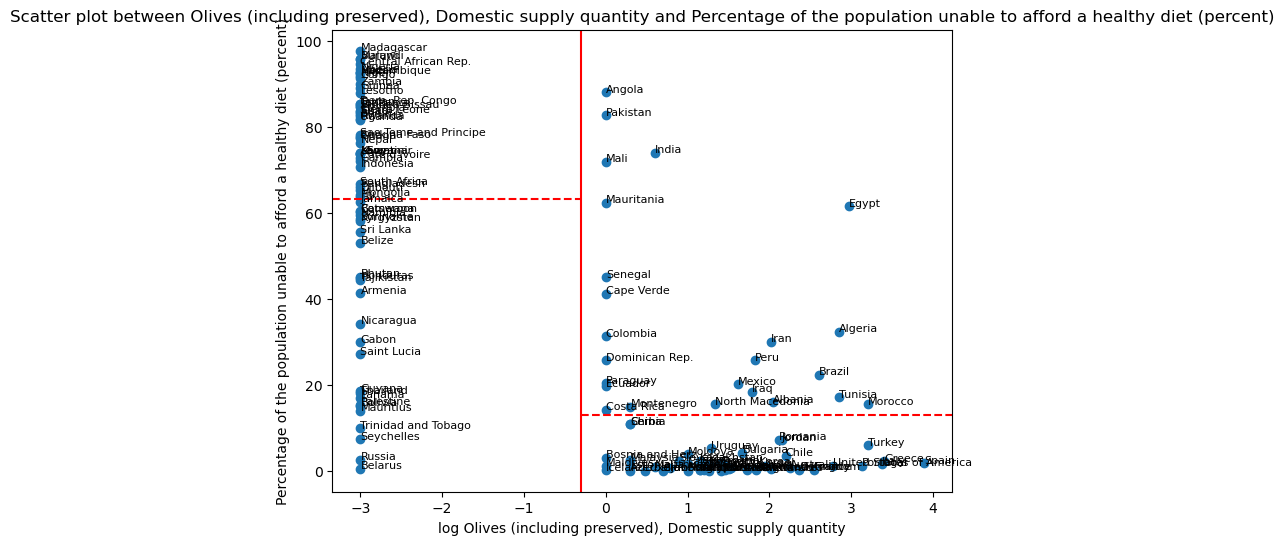

In [39]:
plot_countries(adf, 'Olives (including preserved), Domestic supply quantity', ver_line = 0.5)

**Thus, predictions are made based on geographic location & regional economies, using crops as proxies and we are able to make accurate predictions (MAE <15) using mostly just agricultural production data**

<a id='conclusion'></a>

## **Conclusion**
[Return to contents](#contents)

In conclusion, our best model by MAE error was the Random Forest with a tree depth of eight. We started by preprocessing our data, dropping columns with excessive null values, and imputing 0s in other places. In our EDA, we discovered our largest problem was with the high dimensionality of our data, and our baseline model of linear regression reflected this as it perfectly overfitted the data. We used candidate models that we felt best dealt with the multicollinearity of the features. For our parametric models, we utilized a Lasso Regression and a Correlation Analysis Regression as possible candidate models, and a PCA regression as well. We then decided to look at non-parametric models, which performed much better. These models were the decision tree and random forest. Finally, we used an ensemble method called blending to combine all of our best models in a meta model to make predictions. The Random forest, decision tree, and blended model performed the best. 

Although RF was our best model, it is important to put the model back in context. In this case, interpretability is a critical factor, and a random forest does not show interpretable concrete relationships between the features. We believe that coupled with the feature importance map, this decrease in interpretability is worth the additional model performance, especially because we can point to the important features in the feature importance map. However, in the case that further interpretability is needed, the Lasso Regression or Decision Tree may both be better options.

As we noted, the model seems to be capturing the geography and regional economies of countries to predict our response variable. This means that the strongest predictors of the percentage of people unable to afford a healthy diet might be more closely related to geopolitical factors rather than agricultural ones. Still, our model can achieve shockingly good performance and can help highlight which countries should integrate themselves more in the global marketplace if they are underperforming relative to their neighbors. Overall, the model shows that European and North American countries can best provide healthy, affordable diets, while countries in Africa and South Asia still struggle. Our model might be especially helpful for international aid organizations like the UN or the World Bank to help distribute food and micro-loans to stimulate local agricultural economies.

<a id='future'></a>

## **Future Work**
[Return to contents](#contents)

- Reassessing Geographic Correlations: The current utilization of olive production as a proxy for geographical markers requires further investigation. Future work will involve scrutinizing whether the observed correlation is indeed a meaningful indicator of climate and geographical location, such as distinguishing patterns between regions like Africa and Europe.
- Exploring Additional Data Domains: FAOSTAT offers a diverse range of data domains. Exploring beyond crop production, factors like food accessibility may unveil more robust predictors of the percentage of the population unable to afford a healthy diet. This opens avenues for a more comprehensive understanding of the underlying dynamics. Possible extensions incude using more political markers or economic benchmarks to train a similar model that will also capture socio-economic conditions in a country. 
- KNN Imputation for Missing Data: To address missing data more effectively, the future strategy involves implementing KNN (k-nearest neighbors) imputation instead of imputing zeros. This approach is expected to provide a more nuanced and accurate estimation of missing values, contributing to the overall robustness of the predictive model.
- Policy-Driven Classification Model: We can work on developing a classification model tailored to suggest effective policy measures for countries based on their crop production and yield. This model will aim to provide actionable insights for policymakers to enhance food affordability.
- Diversifying Analysis of Livestock and External Factors: Broadening the scope of analysis to include livestock and external factors, such as distinguishing between urban and rural food accessibility, will enrich the understanding of affordability dynamics. This comprehensive approach ensures a more holistic perspective when assessing the challenges and opportunities related to healthy diet accessibility.